In [1]:
import tensorflow


In [3]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from osgeo import gdal

In [4]:
from tensorflow.keras.layers import Input,Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D,Dropout
from tensorflow.keras.models import Model

In [5]:
def raster2rgb(img_data):
	bands_count = img_data.RasterCount
	
	r = img_data.GetRasterBand(4)
	g = img_data.GetRasterBand(3)
	b = img_data.GetRasterBand(2)
	
	r1 = r.ReadAsArray()
	g1 = g.ReadAsArray()
	b1 = b.ReadAsArray()
	
	img = np.dstack((r1,g1,b1))
	
	out = np.zeros_like(img).astype(np.float32)
	n = img.shape[2]
	for i in range(n):
		a, b = 0, 1
		c = np.percentile(img[:,:,i],2)
		d = np.percentile(img[:,:,i],98)
		t = a +(img[:,:,i]-c)*(b-a)/(d-c)
		t[t<a] = a
		t[t>b] = b
		out[:,:,i] = t
		
	return out


In [6]:
total_images_path = 'D:/vision_impulse/images/'
total_images = []

for file in glob.iglob(total_images_path+'**/*.tif',recursive = True):
	image = gdal.Open(file,gdal.GA_ReadOnly)
	output_image = raster2rgb(image)
	total_images.append(output_image)

In [7]:
print(len(total_images))

5686


In [9]:
	
X_train = []
X_valid = []
X_test = []

for i in range(0,4506):
	X_train.append(total_images[i])
	
for i in range(4506,4506+1100):
	X_valid.append(total_images[i])
	
for i in range(4506+1100,len(total_images)):
	X_test.append(total_images[i])
	

In [10]:
	
X_train = np.asarray(X_train)
X_valid = np.asarray(X_valid)
X_test = np.asarray(X_test)


In [13]:
def raster2label(img_data):
	bands_count = img_data.RasterCount
	if bands_count ==1:
		gray = img_data.GetRasterBand(1)
	
		gray1 = gray.ReadAsArray()
	
		label = np.asarray(gray1)
		
	return label
label_data_path = 'D:/vision_impulse/labels/'
total_labels = []

for file in glob.iglob(label_data_path+'**/*.tif',recursive=True):
	label = gdal.Open(file, gdal.GA_ReadOnly)
	output_label = raster2label(label)
	total_labels.append(output_label)


In [14]:
y_train = []
y_valid = []
y_test = []

for i in range(0,4506):
	y_train.append(total_labels[i])

for i in range(4506,4506+1100):
	y_valid.append(total_labels[i])

for i in range(4506+1100,len(total_labels)):
	y_test.append(total_labels[i])



y_train = np.asarray(y_train)
y_valid = np.asarray(y_valid)
y_test = np.asarray(y_test)

In [15]:
from keras import backend as K
coeff = 1e-10
def IOU(y_true, y_pred):
  intersect = K.sum(y_true*y_predd, axis = [0,-1,-2])
  total = K.sum(y_true+y_pred, axis = [0,-1.-2])
  uniom = total- intersect
  iou = (intersect+coeff)/(union+coeff)

  return K.mean(iou)


In [24]:
#learning rate changes

lr = 1e-4
def lr_rate_scheduler(epoch):
  if 15<epoch<25:
    lr = lr*0.1
  elif 25<epoch<30:
    lr = lr*0.01

  return lr

  

In [18]:
print(X_train.shape)
print(X_test.shape)
print(X_valid.shape)
print(y_train.shape)
print(y_test.shape)
print(y_valid.shape)

(4506, 64, 64, 3)
(80, 64, 64, 3)
(1100, 64, 64, 3)
(4506, 64, 64)
(80, 64, 64)
(1100, 64, 64)


In [19]:
filepath = 'D:/vision_impulse/weights-{epoch:02d}-{val_IOU:4f}.hdf5'

ckpt = tensorflow.keras.callbacks.ModelCkeckpoint(filepath = filepath, monitor ='val_loss',verbose=1,save_best_only= True, mode= 'auto')

rlrp = tensorflow.keras.callbacks.LearningRateScheduler(Lr_rate_scheduler, verbose=1)



AttributeError: module 'tensorflow.keras.callbacks' has no attribute 'ModelCkeckpoint'

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler


In [25]:
filepath = 'D:/vision_impulse/weights-{epoch:02d}-{val_IOU:4f}.hdf5'

ckpt = ModelCheckpoint(filepath = filepath, monitor ='val_loss',verbose=1,save_best_only= True, mode= 'auto')

rlrp = LearningRateScheduler(lr_rate_scheduler, verbose=1)



In [28]:
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D,Conv2DTranspose, concatenate,UpSampling2D
input_lr = Input(shape = (64,64,3))

c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(input_lr)
c1 = Dropout(0.1)(c1)
c1 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = MaxPooling2D((2, 2))(c1)

c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = Dropout(0.1)(c2)
c2 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = MaxPooling2D((2, 2))(c2)

c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(1024, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

u6 = Conv2DTranspose(512,(2, 2), strides=(2, 2),padding='same')(c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = Dropout(0.2)(c6)
c6 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = Conv2DTranspose(256,(2, 2), strides=(2, 2),padding='same')(c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = Dropout(0.2)(c7)
c7 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = Conv2DTranspose(128,(2, 2), strides=(2, 2),padding='same')(c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = Dropout(0.1)(c8)
c8 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = Conv2DTranspose(64,(2, 2), strides=(2, 2),padding='same')(c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

seg_model = Model(inputs=[input_lr],outputs = [outputs])

In [43]:
from tensorflow.keras.optimizers import Adam

seg_model.compile(optimizer=Adam(1e-4),loss='binary_crossentropy',metrics=['accuracy'])

In [44]:
batch_size = 32
steps_per_epoch = int(len(X_train)//batch_size)
epochs = 30

In [46]:
history = seg_model.fit(X_train,y_train, epochs=epochs,steps_per_epoch= steps_per_epoch, validation_data =(X_valid, y_valid),callbacks = None )


Epoch 1/30
140/140 [==============================] - 81s 580ms/step - loss: -0.0101 - accuracy: 0.6210 - val_loss: -0.1003 - val_accuracy: 0.6319
Epoch 2/30
140/140 [==============================] - 81s 580ms/step - loss: -0.3425 - accuracy: 0.6535 - val_loss: -0.1638 - val_accuracy: 0.6484
Epoch 3/30
140/140 [==============================] - 81s 580ms/step - loss: -0.4899 - accuracy: 0.6711 - val_loss: -0.2329 - val_accuracy: 0.6852
Epoch 4/30
140/140 [==============================] - 81s 581ms/step - loss: -0.5342 - accuracy: 0.6760 - val_loss: -0.5690 - val_accuracy: 0.6857
Epoch 5/30
140/140 [==============================] - 81s 582ms/step - loss: -0.6697 - accuracy: 0.6908 - val_loss: 0.3050 - val_accuracy: 0.6890
Epoch 6/30
140/140 [==============================] - 82s 583ms/step - loss: -0.7686 - accuracy: 0.6954 - val_loss: -0.0605 - val_accuracy: 0.6926
Epoch 7/30
140/140 [==============================] - 82s 583ms/step - loss: -0.7828 - accuracy: 0.7066 - val_loss: 0.1

In [48]:
y_pred =seg_model.predict(X_test)

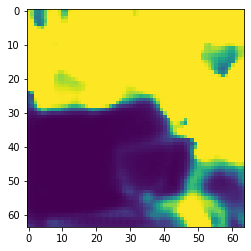

In [50]:
plt.imshow(y_pred[0])

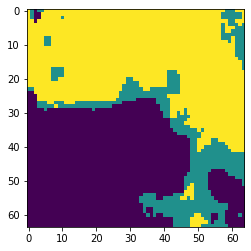

In [51]:
plt.imshow(y_test[0])